<a href="https://colab.research.google.com/github/Catherine-Nguyen88/project_voting/blob/main/DS3001_Project_3_Report_(Group_17).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**`DS3001 Project 2 (Group 17)`**

Isabella Dressel, Camila Gutierrez, Catherine Nguyen, Rhiannon Staley

In [1]:
! git clone https://github.com/Catherine-Nguyen88/project_voting

Cloning into 'project_voting'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 329 (delta 41), reused 40 (delta 25), pack-reused 257
Receiving objects: 100% (329/329), 73.63 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Updating files: 100% (74/74), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression


# **Summary**

# **Data**


# **Results**

We build a decision tree regression model to predict the outcome of the 2024 election in Virginia between Democratic and Republican candidates![prevyearresults.svg](https://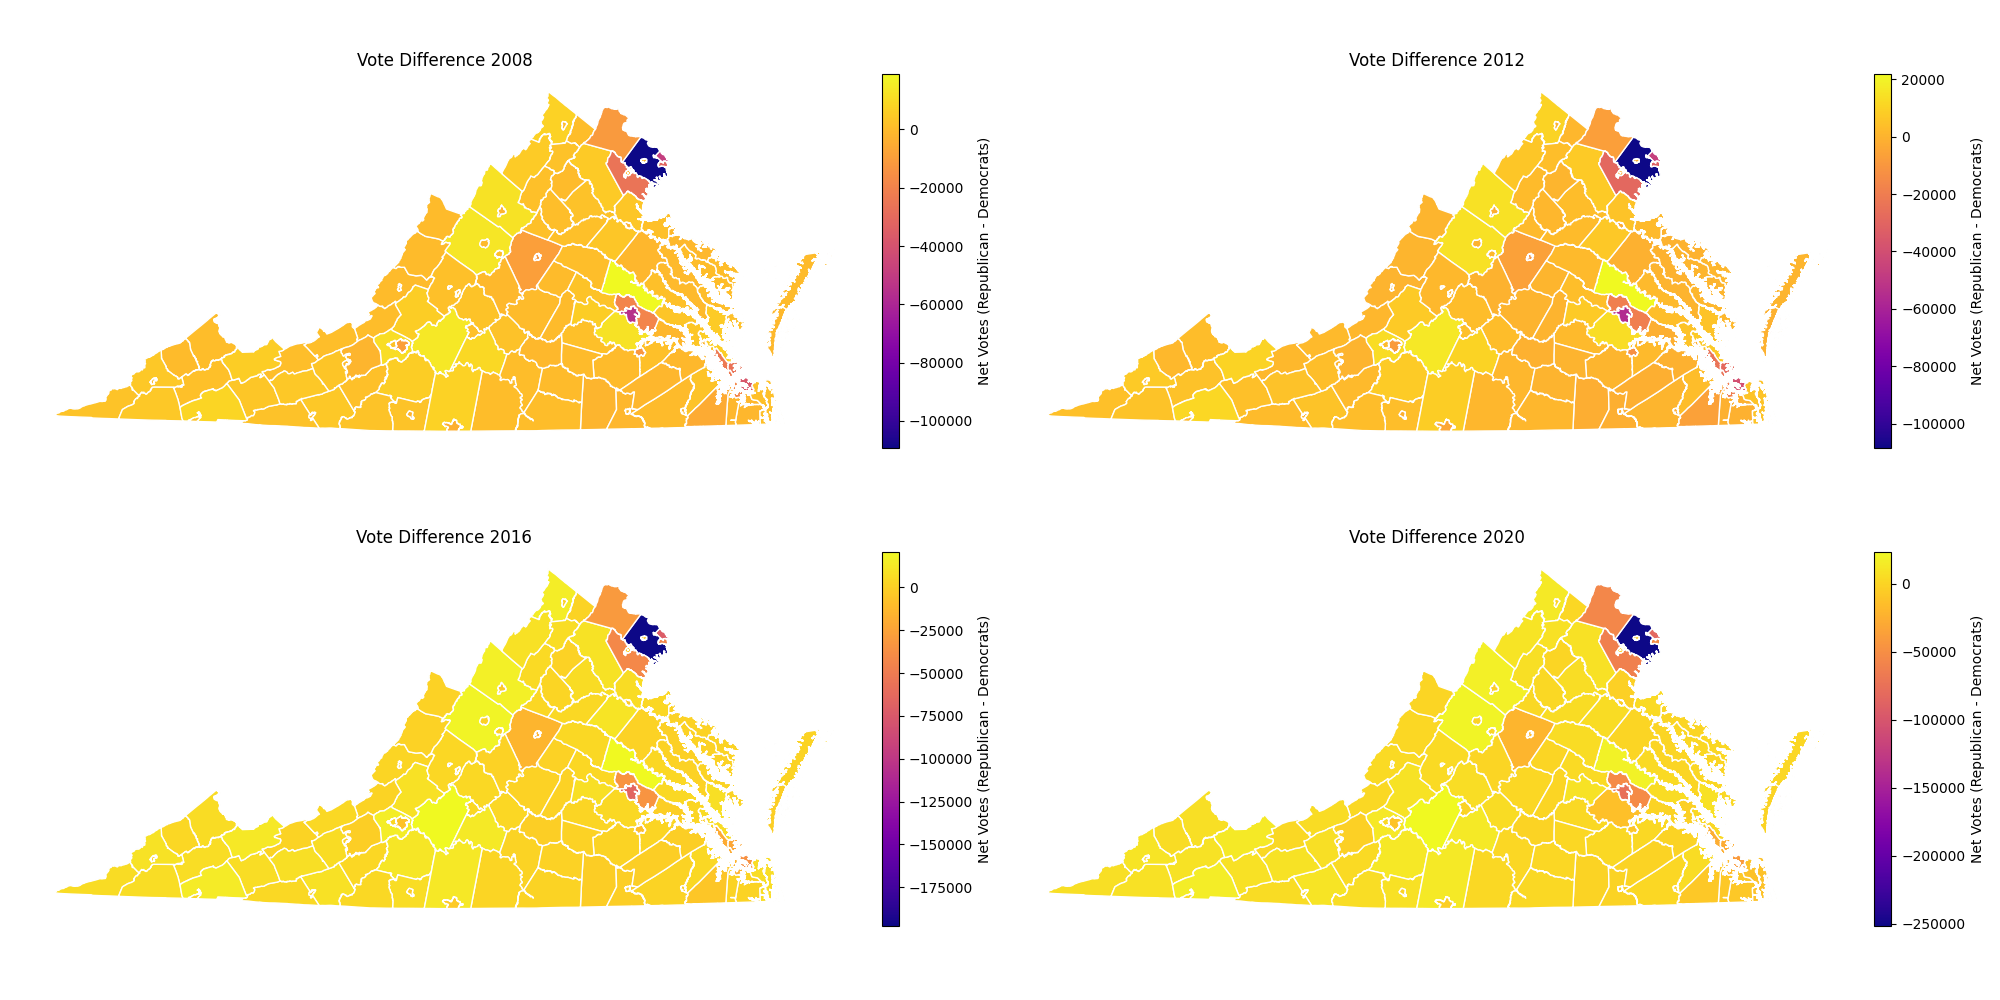). We train and test our model using randomly selected election results in counties from 2008 to 2020, reporting the Rsq and RMSE to evaluate our model. We then use our model to predict the 2024 election based on county-level demographics from the 2018-2022 ACS.

In [3]:
# this is the final df we are using
net_count = pd.read_csv('/content/project_voting/net_votes.csv')
df = net_count.copy() # rename to df
df.head()

,index,year,state,state_po,county_name,county_fips,office,candidatevotes,totalvotes,mode,...,Female: 62 to 64 years,Female: 65 and 66 years,Female: 67 to 69 years,Female: 70 to 74 years,Female: 75 to 79 years,Female: 80 to 84 years,Female: 85 years and over,Total Republican,Total Democrat,Net Vote
0,0,2008,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,7607,15623,TOTAL,...,638,369,690,806,791,441,412,7833,7607,226
1,3,2008,VIRGINIA,VA,ALBEMARLE,51003,US PRESIDENT,29792,50984,TOTAL,...,1468,1038,1161,1884,1546,1470,1269,20576,29792,-9216
2,6,2008,VIRGINIA,VA,ALLEGHANY,51005,US PRESIDENT,3553,7369,TOTAL,...,400,216,391,398,282,302,308,3715,3553,162
3,9,2008,VIRGINIA,VA,AMELIA,51007,US PRESIDENT,2488,6529,TOTAL,...,450,159,230,245,191,97,187,3970,2488,1482
4,12,2008,VIRGINIA,VA,AMHERST,51009,US PRESIDENT,6094,14700,TOTAL,...,662,494,468,722,609,390,460,8470,6094,2376


We perform an initial EDA to understand past voting trends in Virginia. We first explore total vote counts over the 4 election years, which are similar but show an increasing trend from 2008 to 2020 (Figure 1). This could be due to stronger incentives to vote as increased division was present between Democrats and Republicans in the 2020 election, with a similar pattern likely to occur for the 2024 election.

**Figure 1**. Total votes Over the 4 Election Years

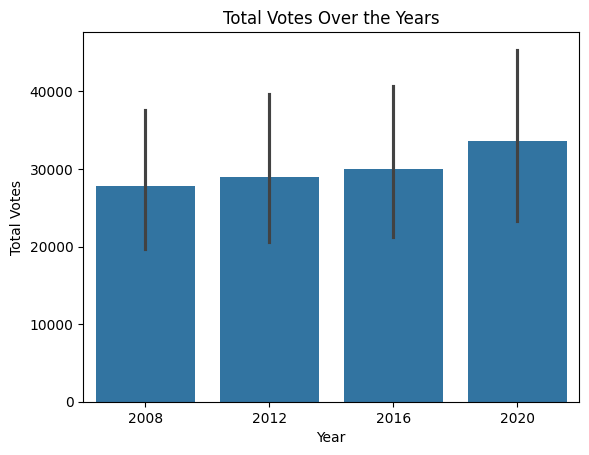

In [4]:
# Total Votes over the year
sns.barplot(x='year', y='totalvotes', data=df)
plt.title('Total Votes Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.show()

## Stacked Barplot: Party Vote Share by Year (Republican vs. Democrat)

We then explore the percentage of party votes for democrats and republicans within each year (Figure 2). For each year, there is almost an even split between Democrats and Republicans, with the majority of votes being for Democratic party candidates by a small margin. Virginia has been a swing state in the past, with a slight preference toward Democratic candidates, as demonstrated in our figure. Based on previous years, this suggests that the 2024 election may follow a similar trend.

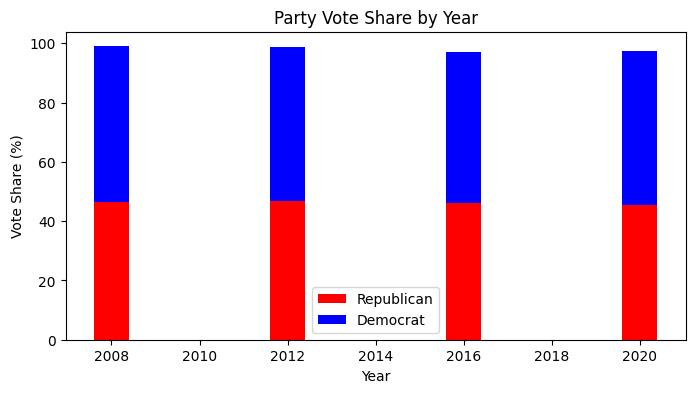

      Total Republican  Total Democrat  totalvotes  Republican Share  \
year                                                                   
2008           1725005         1959532     3723260         46.330501   
2012           1820995         1970595     3851684         46.812227   
2016           1769443         1981473     3984631         45.983031   
2020           1962430         2413568     4462600         45.423752   

      Democrat Share  
year                  
2008       52.629470  
2012       51.883248  
2016       51.140288  
2020       51.960286  


In [5]:
# Party Vote Share by Year (Republican vs. Democrat)
grouped_df = df.groupby('year').sum()

# Calculate cumulative party vote shares as percentages
grouped_df['Republican Share'] = (grouped_df['Total Republican'].cumsum() / grouped_df['totalvotes'].cumsum()) * 100
grouped_df['Democrat Share'] = (grouped_df['Total Democrat'].cumsum() / grouped_df['totalvotes'].cumsum()) * 100

# Create stacked bar plot
plt.figure(figsize=(8, 4))
plt.bar(grouped_df.index, grouped_df['Republican Share'], label='Republican', color='red')
plt.bar(grouped_df.index, grouped_df['Democrat Share'], bottom=grouped_df['Republican Share'], label='Democrat', color='blue')
plt.xlabel('Year')
plt.ylabel('Vote Share (%)')
plt.title('Party Vote Share by Year')
plt.legend()
plt.show()

print(grouped_df[['Total Republican', 'Total Democrat', 'totalvotes', 'Republican Share', 'Democrat Share']])

We explore the net vote, defined as votes for Republican - votes for Democrats for a given county. We sum net votes within a given year to determine outcome of the election. In recent years, Democratic candidates have won the presidential elections in Virginia. The margin that Democrats won by in Virginia doubled in 2020.

We aim to predict net vote to determine whether a Republican or Democrat wins the Virginia election. A negative net vote indicates that a Democrat wins the majority vote across the state, while as a positive vote indicates that a Republiacan wins.

In [6]:
summary_df = df.groupby('year')['Net Vote'].sum().reset_index()
print(summary_df)

   year  Net Vote
0  2008   -234527
1  2012   -149600
2  2016   -212030
3  2020   -451138


We explore the net vote variable, performing an arcsinh transformation to better visualize the distribution and prepare the data for regression analysis. This is appropriate because the data span several orders of magnitude and contain zero and negative values. The arcsinh transofmation compresses large magnitude values and expands small magnitude values. From this, we can easily distinguish a bimodal distribution with a peak at positive net votes and another peak at negative net votes.

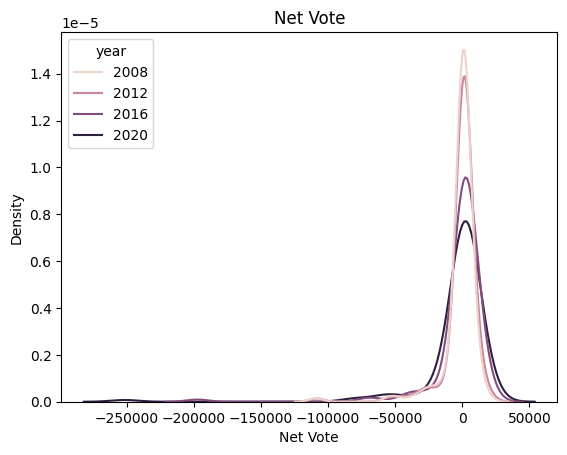

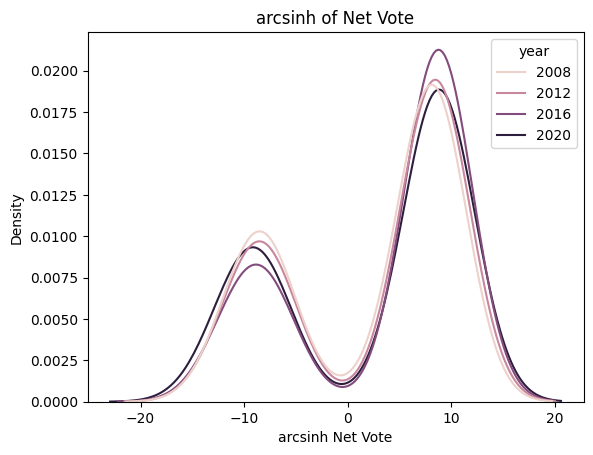

In [7]:
# kde plot of year vs. Net Vote, Total Republican, Total Democrat
sns.kdeplot(data=df, x='Net Vote', hue = 'year')
plt.title('Net Vote')
plt.show()

df['arcsinh Net Vote'] = np.arcsinh(df['Net Vote'])
sns.kdeplot(data=df, x='arcsinh Net Vote', hue='year')
plt.title('arcsinh of Net Vote')
plt.show()


### Predicting the 2024 elecion using decision tree regression

We use decision tree regression to predict the 2024 election based on county-level race-ethnicity, education, and poverty status. We quantify the state-wide election outcome by summing the untransformed predicted net votes.

We split the data into training and testing sets for 2008 to 2020, without considering election years. We use a training size of 80% (426) and testing size of 20% (107) of the total dataset (533).

In [8]:
varnames = ["Not Hispanic or Latino: White alone",
       "Not Hispanic or Latino: Black or African American alone",
       "Not Hispanic or Latino: American Indian and Alaska Native alone",
       "Not Hispanic or Latino: Asian alone",
       "Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone",
       "Not Hispanic or Latino: Two or more races", "Hispanic or Latino",
       "No schooling completed", "Regular high school diploma",
       "GED or alternative credential", "Some college, less than 1 year",
       "Some college, 1 or more years, no degree", "Associate's degree",
       "Bachelor's degree", "Master's degree", "Professional school degree",
       "Doctorate degree", "Under .50", ".50 to .99", "1.00 to 1.24",
       "1.25 to 1.49", "1.50 to 1.84", "1.85 to 1.99", "2.00 and over","county_fips"]

y = df['arcsinh Net Vote']
X = df.loc[:,varnames]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

print(X_train.shape)
print(X_test.shape)
print(X.shape)

(426, 25)
(107, 25)
(533, 25)


We determine the optimal decision tree depth and criterion as shown below. We find that the optimal model uses the friedman_mse criterion and has a depth of 20. The model performance remains high as the tree depth increases, suggesting that overfitting does not occur until higher depths than 20. This could also be due to similarities between the training and test sets due to similar election outcomes between years.

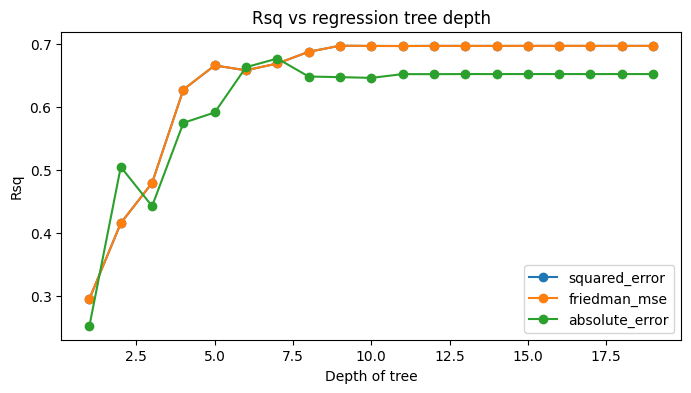

In [9]:
depths = np.arange(1,20,1)
rsq_results = {}
RMSE_results = {}

criterions = ['squared_error', 'friedman_mse', 'absolute_error']
for crit in criterions:
  rsq = []
  RMSE = []
  for dep in depths:
    # fit decision tree with given depth
    cart = DecisionTreeRegressor(max_depth=dep,criterion=crit,min_samples_split=20)
    cart = cart.fit(X_train,y_train) # fit the regression
    var_names = cart.feature_names_in_

    # make predictions on the test set
    y_hat = cart.predict(X_test)

    # residuals, rsq, rmse
    e = y_test - y_hat
    rsq_val = 1-np.sum(e**2)/np.sum((y_test - np.mean(y_train))**2)
    rsq.append(rsq_val)
    rmse_val = np.sqrt(np.mean(e**2))
    RMSE.append(rmse_val)

  rsq_results[crit] = rsq
  RMSE_results[crit] = RMSE

plt.figure(figsize=(8,4))
for crit in criterions:
  plt.plot(depths,rsq_results[crit],marker='o',label=crit)
plt.title("Rsq vs regression tree depth")
plt.legend()
plt.xlabel("Depth of tree")
plt.ylabel("Rsq")
plt.show()

We build a decision tree regressor with a max depth of 10 and friedman MSE as the criterion. The model performs well on the testing dataset, with an Rsq of 0.696 and an RMSE of 59.92 votes (original units), suggesting that the errors in the model are relatively small. Furthermore, the model predicts that Democrats won the election based on the testing dataset by 229,746 votes, which is a very large margin and is consistent with previous years.

The residuals are approximately normally distributed and centered around zero, suggesting there are no major deficiencies in the model.

We show the feature importance for the 10 most influential variables in the model. The top 5 most important predictors are poverty (ratio of income-to-poverty under 0.50), county, Black or African American populations, white populations, and near but above the poverty line (ratio of income-to-poverty of 1.00 to 1.24).

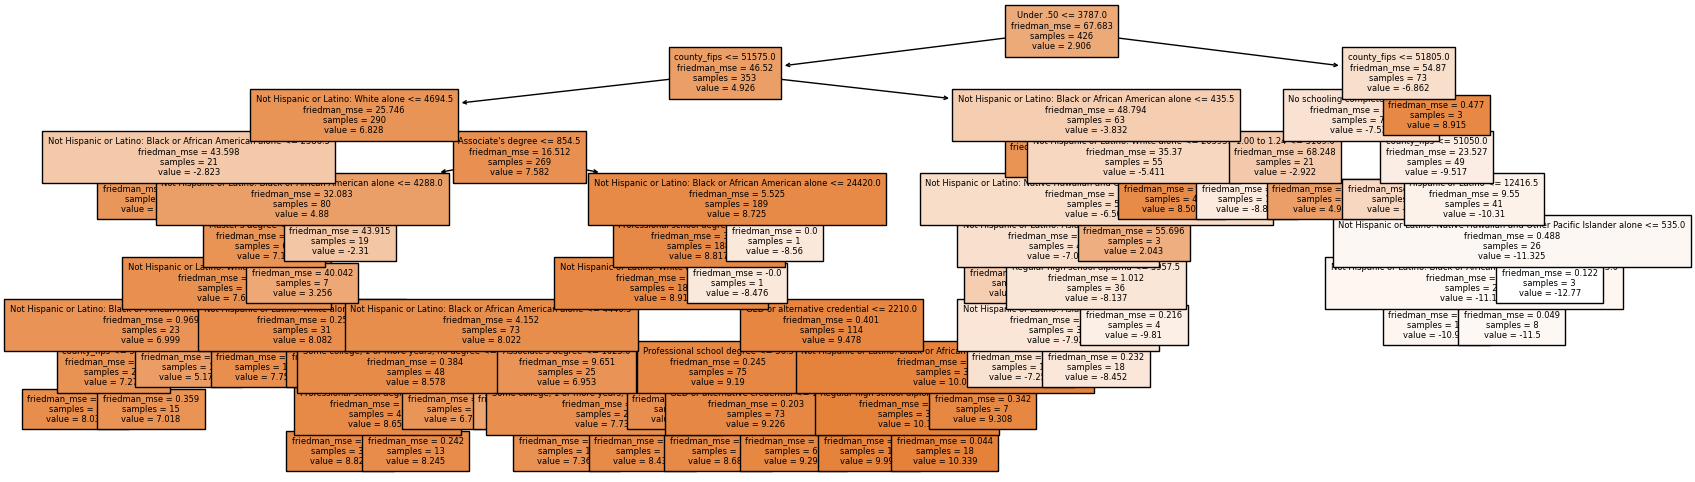

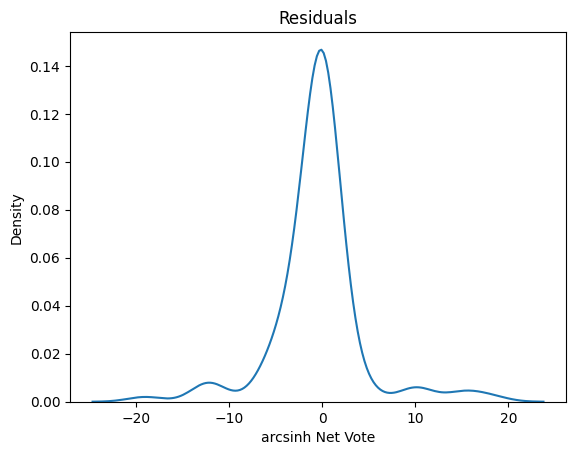

Rsq for tree depth of 10: 0.6961735977141278
RMSE for tree depth of 10: 4.786314994816976
RMSE for tree depth of 10 (original units): 59.92526507520977
Democrats win by 229746.3762406688

 Feature importance: 


,variable,importance
17,Under .50,0.330748
24,county_fips,0.268426
1,Not Hispanic or Latino: Black or African Ameri...,0.143280
0,Not Hispanic or Latino: White alone,0.120323
19,1.00 to 1.24,0.038738
12,Associate's degree,0.035125
7,No schooling completed,0.025156
15,Professional school degree,0.012091
4,Not Hispanic or Latino: Native Hawaiian and Ot...,0.009437
3,Not Hispanic or Latino: Asian alone,0.007311


In [10]:
cart = DecisionTreeRegressor(max_depth=10,criterion='friedman_mse',min_samples_split=20,random_state=1)
cart = cart.fit(X_train,y_train) # fit the regression
# visualize results
var_names = cart.feature_names_in_
plt.figure(figsize=(20,6))
plot_tree(cart, filled=True, feature_names=var_names, fontsize=6)
plt.show()

# make predictions on the test set
y_hat = cart.predict(X_test)

# residuals, rsq, rmse
e = y_test - y_hat
rsq = 1-np.sum(e**2)/np.sum((y_test - np.mean(y_train))**2)
RMSE = np.sqrt(np.mean(e**2))
RMSE_ounits = np.sinh(RMSE)

sns.kdeplot(e)
plt.title('Residuals')
plt.show()

print(f'Rsq for tree depth of 10: {rsq}')
print(f'RMSE for tree depth of 10: {RMSE}')
print(f'RMSE for tree depth of 10 (original units): {RMSE_ounits}')

outcome = np.sum(np.sinh((y_hat))) # democrats win!

if outcome > 0:
  print(f'Republicans win by {outcome}')
else:
  print(f'Democrats win by {-1*outcome}') # print votes they win by (make it positive)

  # print the feature importance
  # use the feature importances to see which variables matter the most
print('\n', 'Feature importance: ')
results = pd.DataFrame({'variable':varnames, 'importance': cart.feature_importances_}) # Regression coefficients
results = results.sort_values(by='importance', ascending=False)
results.head(10)

#### 2024 election

We predict the 2024 election using our trained model with input variables of 2018-2022 ACS demographics, which we assume are equivalent to 2024 demographics.

We find that the Democratic candidate will win in 2024 by a margin of 252,281 votes. This is consistent with voting patterns in recent years. We are confident in our conclusion because the RMSE from our testing dataset has a smaller magnitude than the winning margin, suggesting it is very unlikley that the Republican candidate would win.

In [11]:
dem_2024 = pd.read_csv('./project_voting/demographics_2024.csv')

varnames = ["Not Hispanic or Latino: White alone",
       "Not Hispanic or Latino: Black or African American alone",
       "Not Hispanic or Latino: American Indian and Alaska Native alone",
       "Not Hispanic or Latino: Asian alone",
       "Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander alone",
       "Not Hispanic or Latino: Two or more races", "Hispanic or Latino",
       "No schooling completed", "Regular high school diploma",
       "GED or alternative credential", "Some college, less than 1 year",
       "Some college, 1 or more years, no degree", "Associate's degree",
       "Bachelor's degree", "Master's degree", "Professional school degree",
       "Doctorate degree", "Under .50", ".50 to .99", "1.00 to 1.24",
       "1.25 to 1.49", "1.50 to 1.84", "1.85 to 1.99", "2.00 and over","county_fips"]

X_2024 = dem_2024.loc[:,varnames]

y_2024 = cart.predict(X_2024)

outcome = np.sum(np.sinh((y_2024))) # democrats win!

if outcome > 0:
  print(f'Republicans win by {outcome}')
else:
  print(f'Democrats win by {-1*outcome}') # print votes they win by (make it positive)

Democrats win by 252281.08256823831


We verify our model by comparing the predictions for 2024 and voting patterns of previous years visually. Code is shown in report_maps.ipynb

![title](https://github.com/Catherine-Nguyen88/project_voting/blob/main/prevyearresults.png?raw=1)

![title](https://github.com/Catherine-Nguyen88/project_voting/blob/main/prediction2024.png?raw=1)

# **Conclusion**

# **Appendix**